In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def ignore_warn(*args, **kwargs):
    pass

# ignore annoying warning (from sklearn and seaborn)
warnings.warn = ignore_warn
# Increasing width to 100% on my PC
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Importing the full dataset

In [2]:
df = pd.read_csv('C:\\Users\Admin\\Desktop\\Riskworx\\Paper\\Data\\accepted_2007_to_2018q4.csv\\accepted_2007_to_2018Q4.csv', low_memory=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


We are trying to predict the loan_status column. Let's check the value distributions in this column first.

In [4]:
df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

We will try to distinguish 2 cases: loans being fully paid or charged off, assuming that they both meet the credit policy. We will only keep the rows with loan_status being "fully paid" or "charged off".

In [5]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [6]:
df['loan_status'].value_counts(normalize=False, dropna=False)

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

In [7]:
df['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid    0.800
Charged Off   0.200
Name: loan_status, dtype: float64

80% of the loans have been fully paid, and 20%  have been charged off. Unbalanced data. We will try to handle this unbalance in the cross validation and while picking appropriate metrics.

## Feature Selection and EDA

The raw data has 150 features, but not all of them are useful. Definitions of the columns are given in the Lending Club "Data Dictionary"

We will drop the features with the following criteria:
- More than 50% of the data is missing
- The feature would not have been available at the time of the loan application ("issue_d").

We will also address the following:

- convert strings to numerical values
- drop superfluous attributes
- highly correlated predictors
- zero (or nearly zero) variance predictors

In [8]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [9]:
missing_values_table(df)

Your selected dataframe has 151 columns.
There are 105 columns that have missing values.


,Missing Values,% of Total Values,type
member_id,1345310,100.000,float64
next_pymnt_d,1345310,100.000,object
orig_projected_additional_accrued_interest,1341551,99.700,float64
hardship_type,1339556,99.600,object
hardship_reason,1339556,99.600,object
...,...,...,...
chargeoff_within_12_mths,56,0.000,float64
last_credit_pull_d,55,0.000,object
tax_liens,39,0.000,float64
inq_last_6mths,1,0.000,float64


From this table, we can see that there is a huge gap between features missing some data (~15% and below) and those missing lots of data (up to 100%!). We chose 20% as the cutoff.

In [10]:
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.20].index)

In [11]:
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [12]:
len(drop_list)

58

In [13]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [14]:
drop_cols(drop_list)

In [15]:
df.shape

(1345310, 93)

The goal of this project is to predict whether a loan will be paid off BEFORE making the decision to lend the loan. Therefore, we would like to remove the features that were unavailable before lending a loan.

In [16]:
drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']

In [17]:
len(drop_list)

58

In [18]:
drop_cols(drop_list)

In [19]:
print(sorted(df.columns))

['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'open_acc', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'url', 'verification_status', 'zip_code']


In [20]:
len(df.columns)

35

In [21]:
drop_list = ['sub_grade', 'emp_title', 'zip_code',
                          'addr_state', 'issue_d',
                          'title',
                          'initial_list_status',
                          'application_type',
                          ]

In [22]:
drop_cols(drop_list)

In [23]:
print(sorted(df.columns))

['annual_inc', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'open_acc', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'term', 'total_acc', 'url', 'verification_status']


In [24]:
len(df.columns)

27

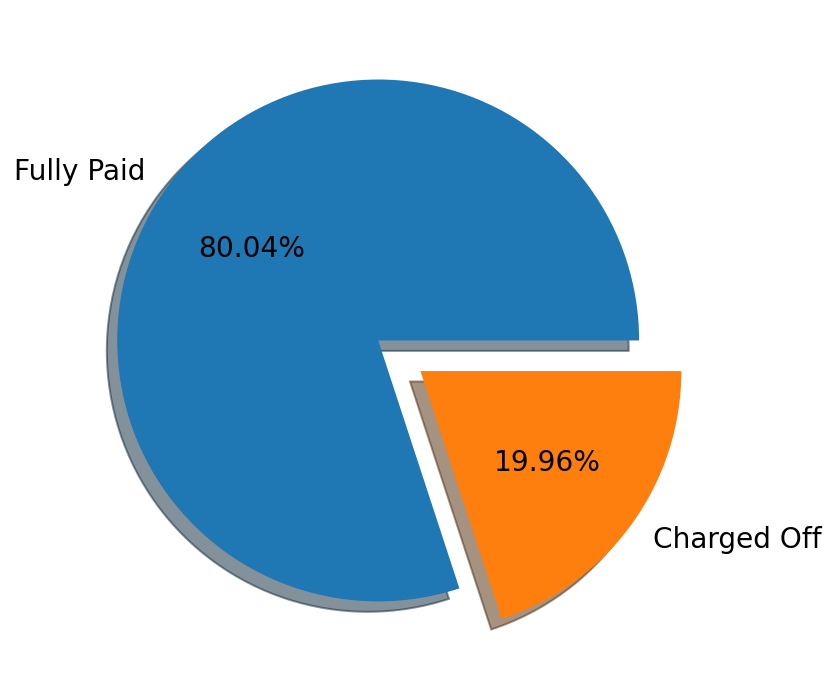

In [25]:
plt.figure(figsize=(8,6))
plt.pie(df.loan_status.value_counts(), labels=df.loan_status.unique(),
        explode=(0, 0.2), autopct='%1.2f%%', shadow=True, textprops={'fontsize': 14});

<AxesSubplot:xlabel='loan_status', ylabel='count'>

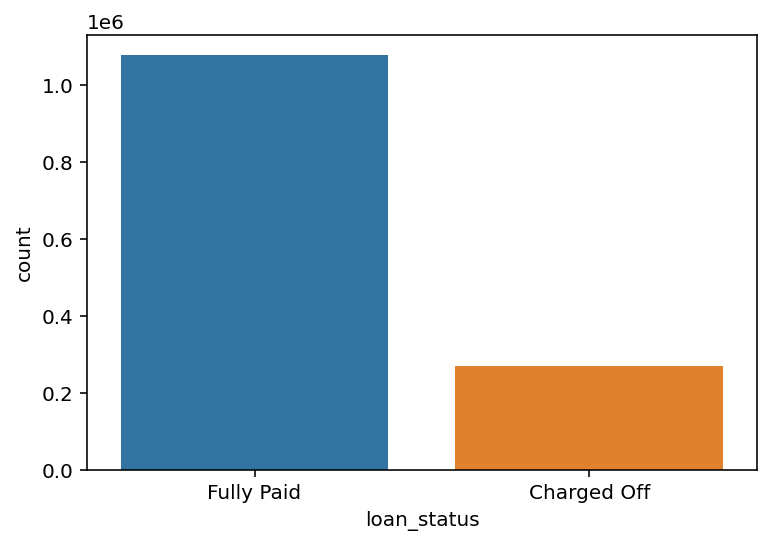

In [26]:
sns.countplot(df.loan_status)

Text(0.5, 1.0, 'Purpose of Loan')

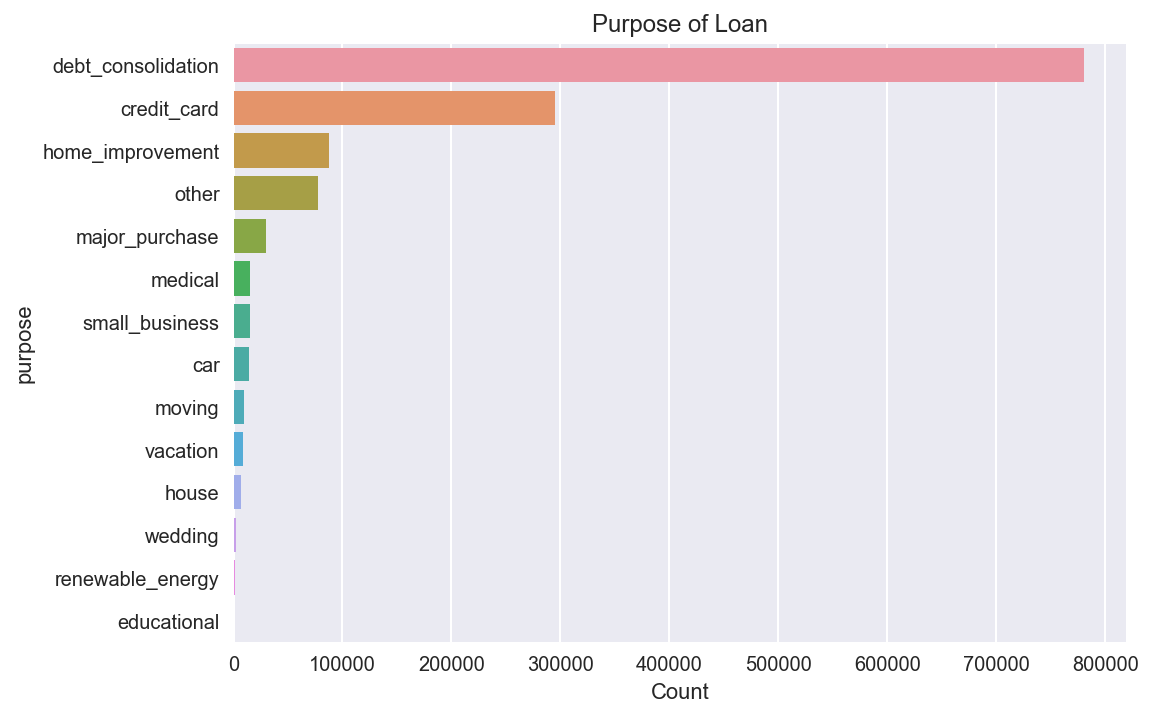

In [27]:
# Loan Purpose
plt.style.use('seaborn')
sns.countplot(y="purpose", data=df,
              order=df["purpose"].value_counts().index)
plt.xlabel('Count')
plt.title('Purpose of Loan')

In [28]:
df['term'].value_counts(normalize=True)

 36 months   0.759
 60 months   0.241
Name: term, dtype: float64

About 76% of the loans are 36 months and the rest are 60 months. The latter tends to have lower fraction of being fully paid.

In [29]:
df.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
 36 months   0.160
 60 months   0.324
Name: loan_status, dtype: float64

16% of the 36-month loans are charge off, while 32% of the 60-month are charged off. Longer term leads to higher charged off - This feature should be useful in modeling.

In [30]:
df['int_rate'].describe()

count   1345310.000
mean         13.240
std           4.769
min           5.310
25%           9.750
50%          12.740
75%          15.990
max          30.990
Name: int_rate, dtype: float64

The interest rage ranges from 5% to 31%, with a median at 13%.

In [31]:
# make general plots to examine each feature
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,'Charged Off']
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'loan_status', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loan_status', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()

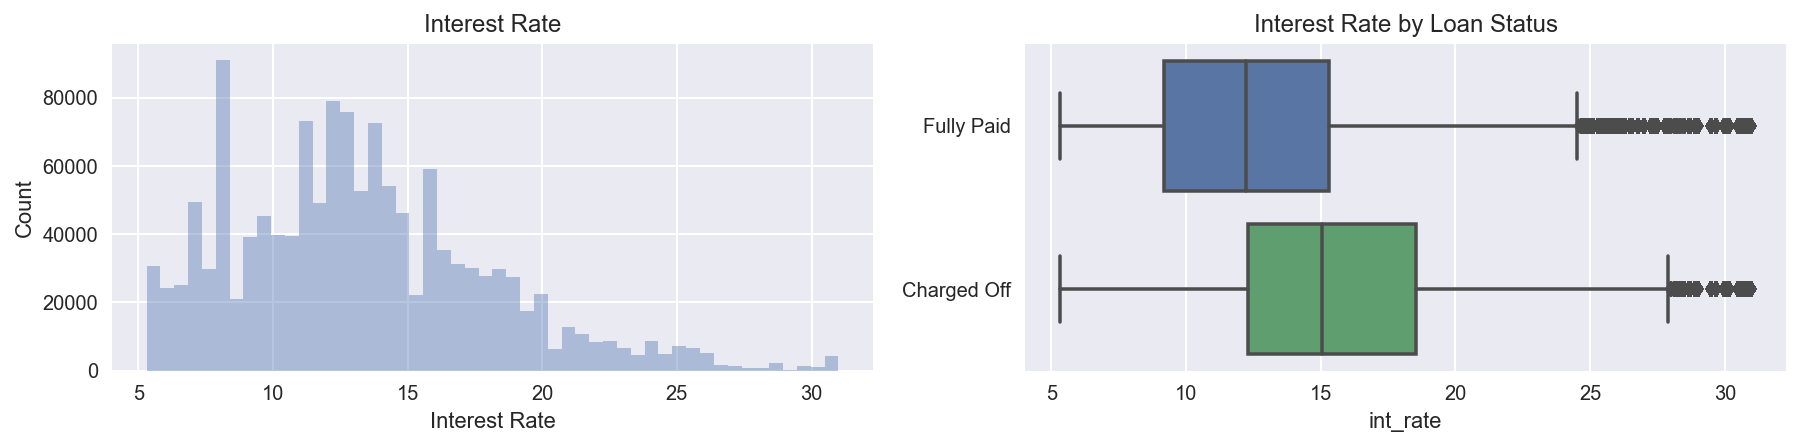

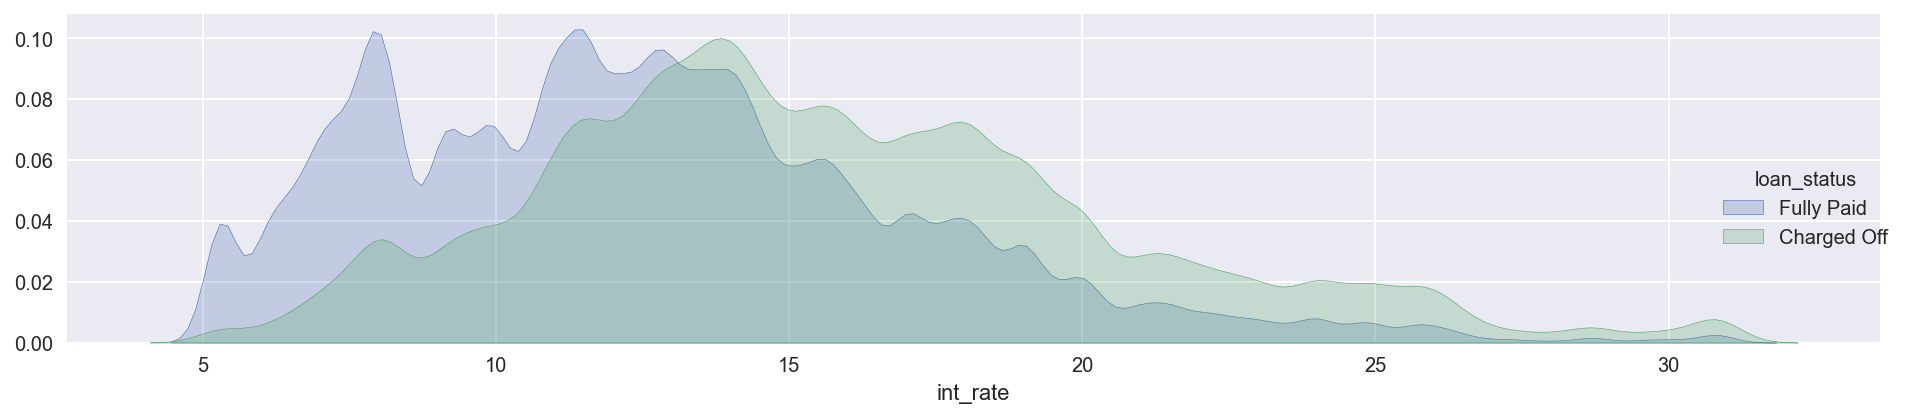

In [32]:
plot_var('int_rate', 'Interest Rate', continuous=True)

The higher the interest rate is, the more likely for being charged off. There are some outliers in the Fully Paid dataset. Let's take a look at them, as outliers may distort ML analysis.

In [33]:
df.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.000,15.711,4.910,5.310,12.290,15.050,18.550,30.990
Fully Paid,1076751.000,12.623,4.527,5.310,9.170,12.230,15.310,30.990


In [34]:
(df.loc[(df.int_rate > 15.61) & (df.loan_status == 'Fully Paid')].shape[0])/df['loan_status'].value_counts(normalize=False, dropna=False)[0]

0.21762598780962358

In [35]:
df.loc[(df.int_rate >18.55) & (df.loan_status == 'Charged Off')].shape[0]/df['loan_status'].value_counts(normalize=False, dropna=False)[1]

0.245521468280713

The percentage of outliers is roughly the same for the Fully Paid/Charged off data, ~23%. A bit too much to be dropped. We will keep these outliers for now.

Removing conflicting data

In [36]:
sorted(df.columns)

['annual_inc',
 'dti',
 'earliest_cr_line',
 'emp_length',
 'fico_range_high',
 'fico_range_low',
 'grade',
 'home_ownership',
 'id',
 'installment',
 'int_rate',
 'loan_amnt',
 'loan_status',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mort_acc',
 'open_acc',
 'policy_code',
 'pub_rec',
 'pub_rec_bankruptcies',
 'purpose',
 'revol_bal',
 'revol_util',
 'term',
 'total_acc',
 'url',
 'verification_status']

In [37]:
drop_list = ['emp_length','fico_range_high','fico_range_low','home_ownership','id','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','policy_code','total_acc','url','verification_status']

In [38]:
drop_cols(drop_list)

In [39]:
len(df.columns)

16

<AxesSubplot:xlabel='grade', ylabel='count'>

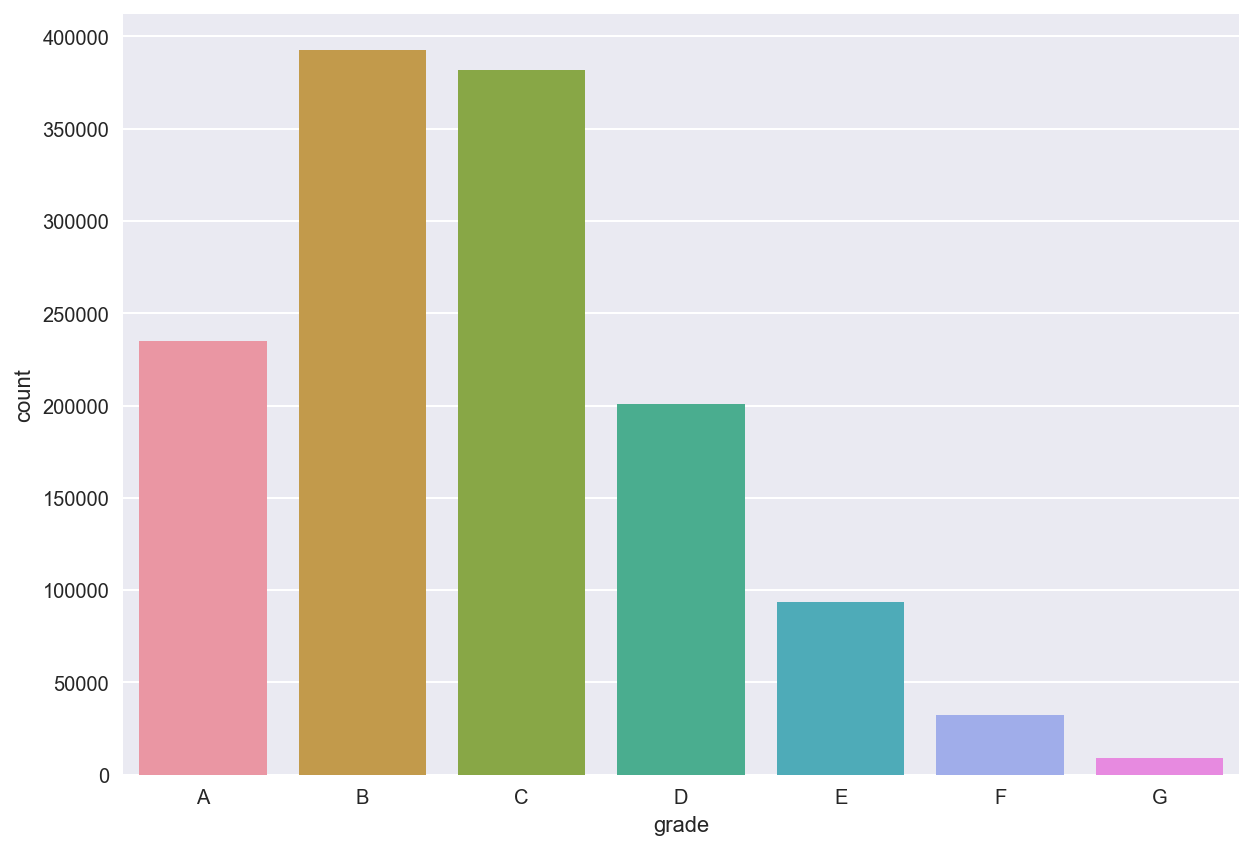

In [40]:
plt.figure(figsize=(10, 7))
sns.countplot(x="grade", data=df, order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

<AxesSubplot:>

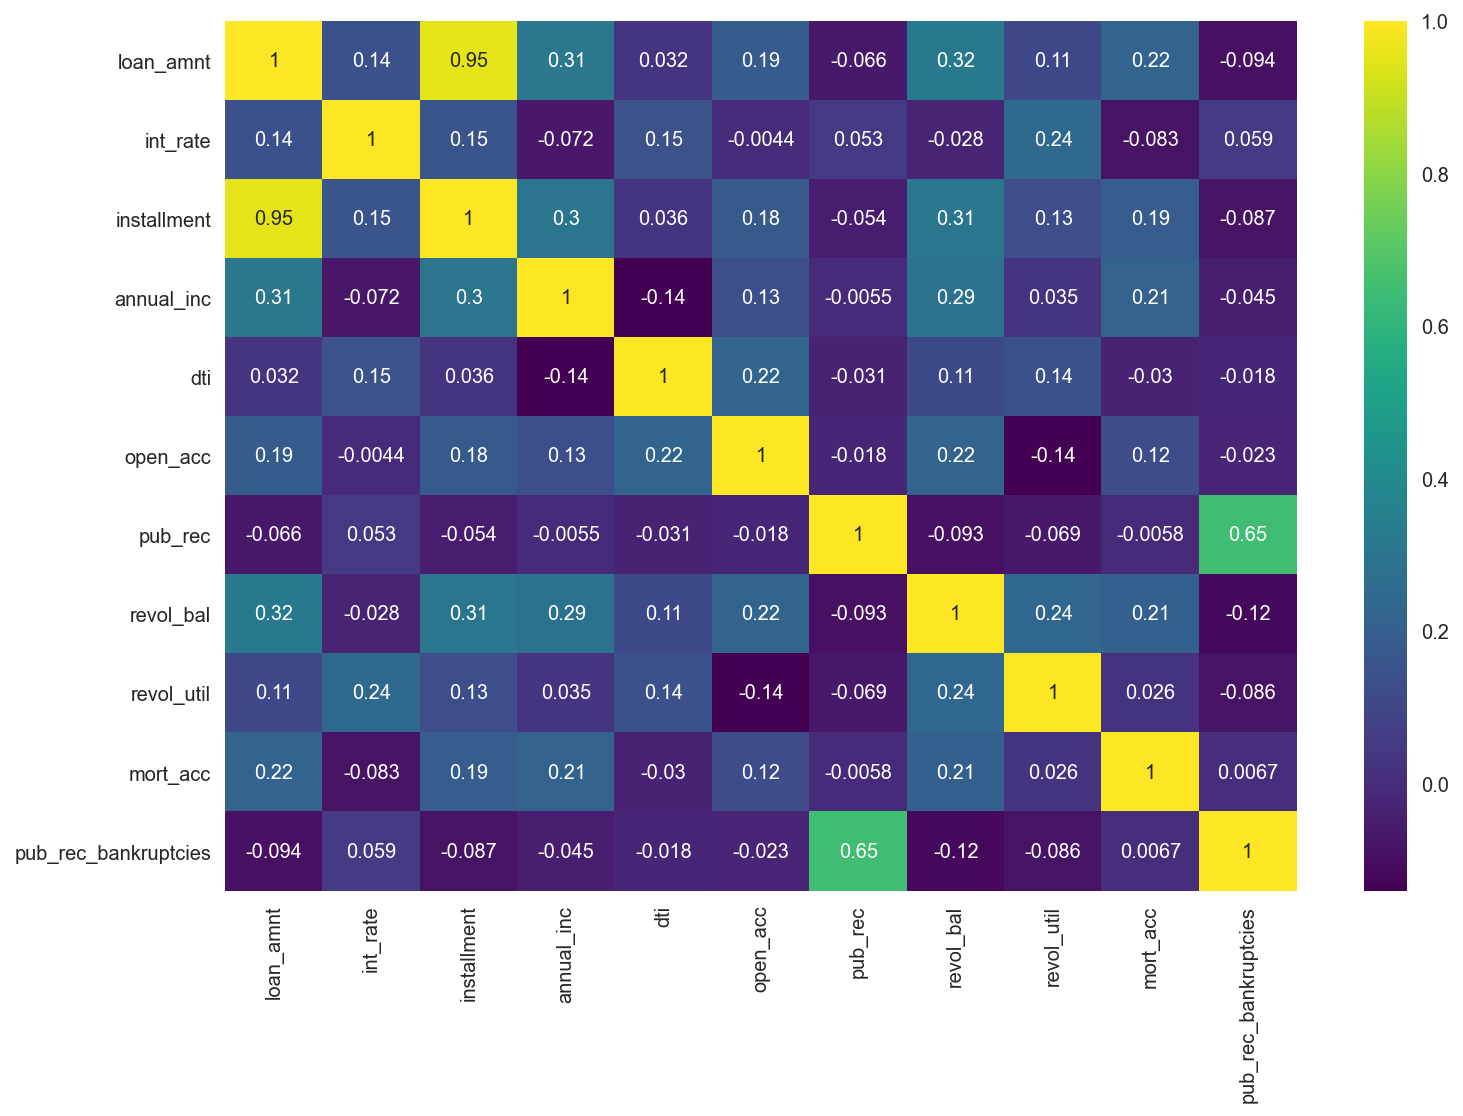

In [41]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

In [42]:
df[df.annual_inc >= 1000000].shape

(339, 16)

Only 339 borrowers have an annual income more than 1 million.

In [43]:
sorted(df.columns)

['annual_inc',
 'dti',
 'earliest_cr_line',
 'grade',
 'installment',
 'int_rate',
 'loan_amnt',
 'loan_status',
 'mort_acc',
 'open_acc',
 'pub_rec',
 'pub_rec_bankruptcies',
 'purpose',
 'revol_bal',
 'revol_util',
 'term']

In [44]:
df.head()

,loan_amnt,term,int_rate,installment,grade,annual_inc,loan_status,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies
0,3600.000,36 months,13.990,123.030,C,55000.000,Fully Paid,debt_consolidation,5.910,Aug-2003,7.000,0.000,2765.000,29.700,1.000,0.000
1,24700.000,36 months,11.990,820.280,C,65000.000,Fully Paid,small_business,16.060,Dec-1999,22.000,0.000,21470.000,19.200,4.000,0.000
2,20000.000,60 months,10.780,432.660,B,63000.000,Fully Paid,home_improvement,10.780,Aug-2000,6.000,0.000,7869.000,56.200,5.000,0.000
4,10400.000,60 months,22.450,289.910,F,104433.000,Fully Paid,major_purchase,25.370,Jun-1998,12.000,0.000,21929.000,64.500,6.000,0.000
5,11950.000,36 months,13.440,405.180,C,34000.000,Fully Paid,debt_consolidation,10.200,Oct-1987,5.000,0.000,8822.000,68.400,0.000,0.000


features such as earliest_cr_line contain dates that we are not going to use in my models. Let's drop it.

In [45]:
df.drop(['earliest_cr_line'], axis=1, inplace=True, errors='ignore')

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.000,15565.055,8814.560,900.000,9000.000,14350.000,20400.000,40000.000
Fully Paid,1076751.000,14134.370,8669.029,500.000,7500.000,12000.000,20000.000,40000.000


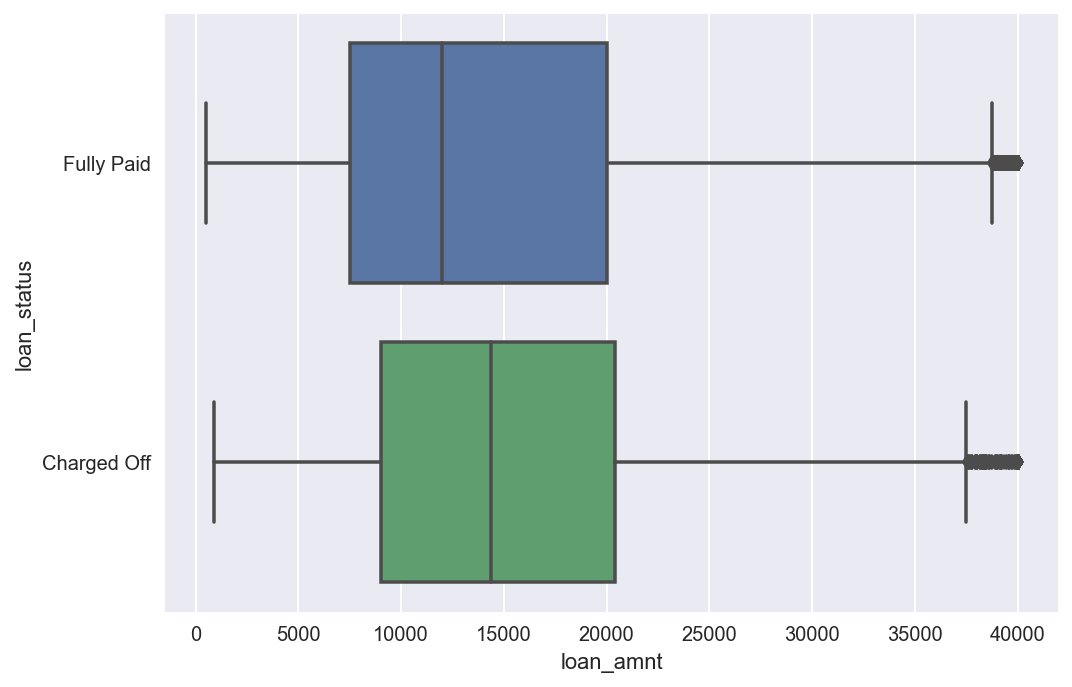

In [46]:
sns.boxplot(x=df.loan_amnt, y=df.loan_status.astype(str))
df.groupby(['loan_status'])['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.000,70400.743,65394.909,0.000,43000.000,60000.000,85000.000,9500000.000
Fully Paid,1076751.000,77705.946,70934.960,0.000,47000.000,65000.000,93000.000,10999200.000


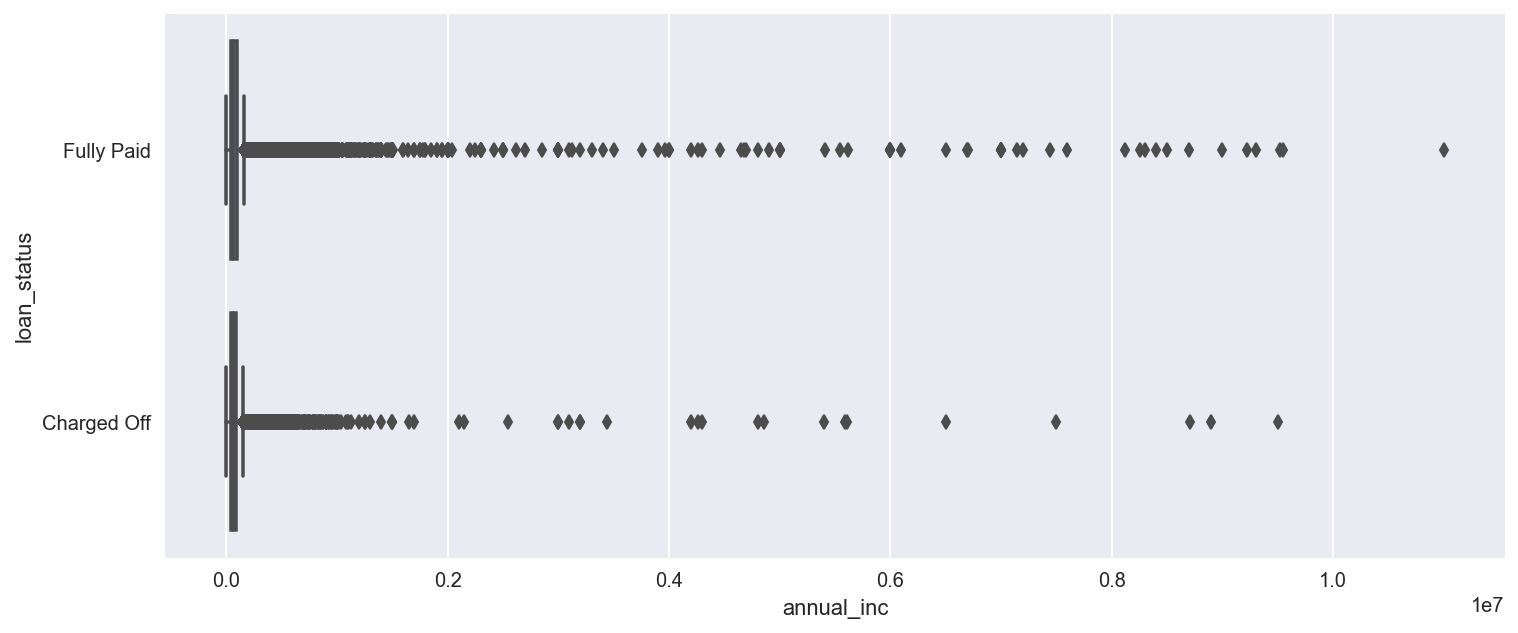

In [47]:
plt.figure(figsize=(12,5))
sns.boxplot(x=df.annual_inc, y=df.loan_status.astype(str))
df.groupby(['loan_status'])['annual_inc'].describe()

This feature has too many outliers. In order to fix this problem, let's use apply logarithm.

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.000,-inf,NaN,-inf,10.669,11.002,11.350,16.067
Fully Paid,1076751.000,-inf,NaN,-inf,10.758,11.082,11.440,16.213


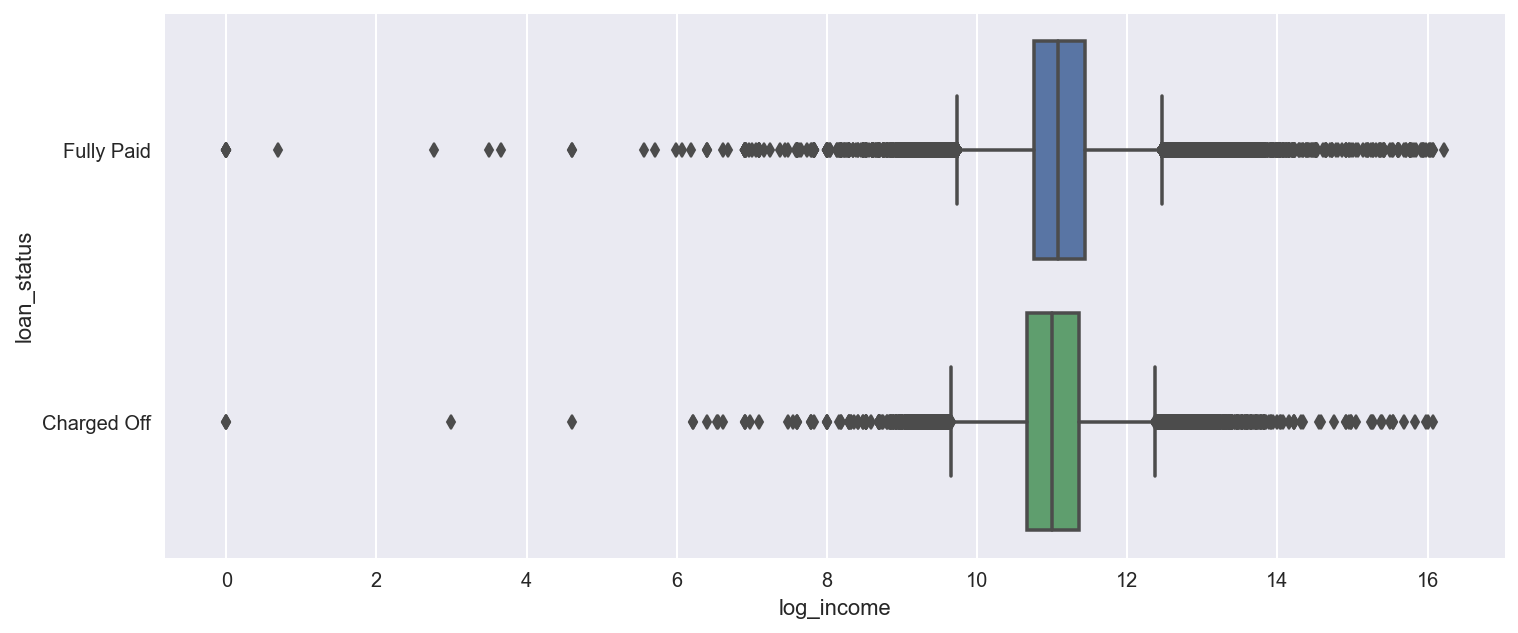

In [48]:
df['log_income'] = np.log(df.annual_inc)
plt.figure(figsize=(12,5))
sns.boxplot(x=df.log_income, y=df.loan_status.astype(str))
df.groupby(['loan_status'])['log_income'].describe()

In [49]:
df.drop(columns=['annual_inc'], inplace=True)

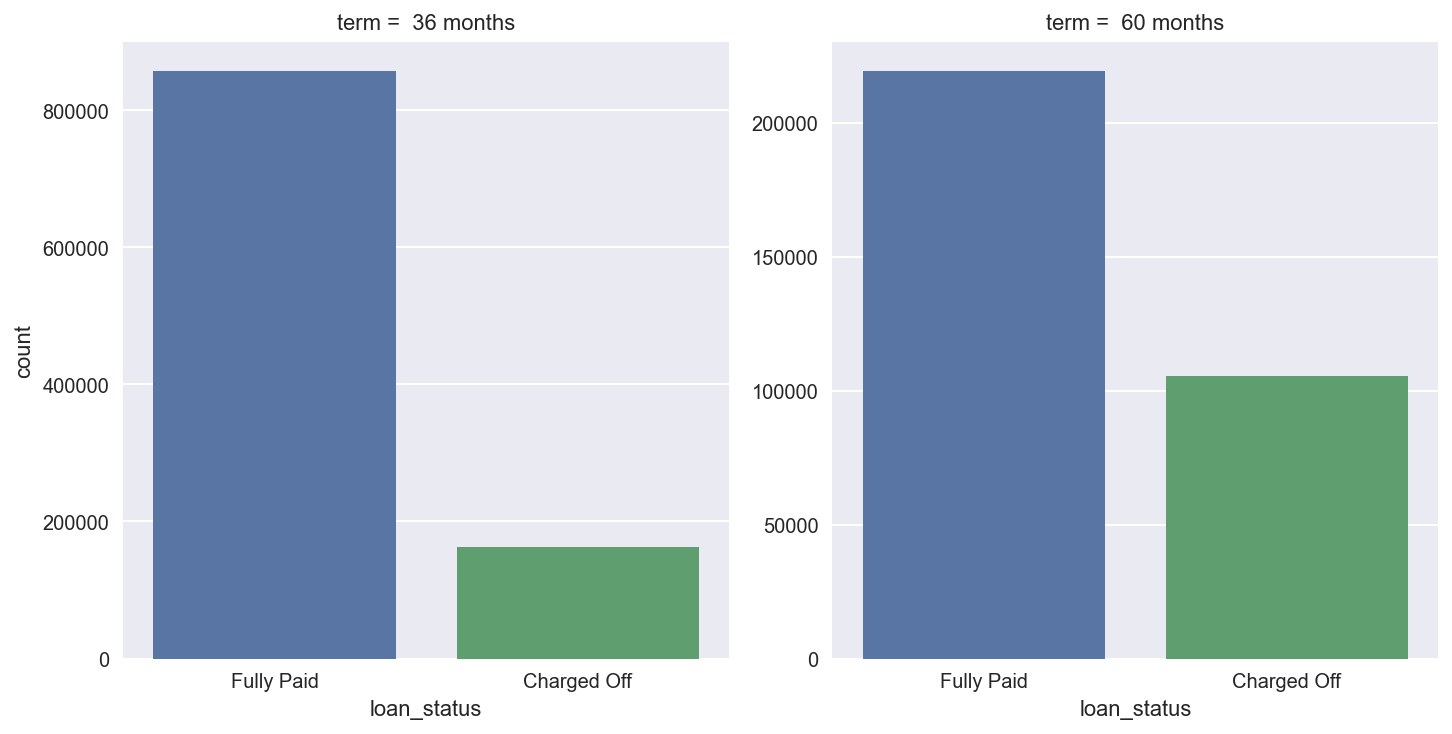

In [50]:
sns.catplot(data=df, x='loan_status', kind='count', col='term', height=5, sharey=False);

Loans with higher term are significantly more likely to be charged off and thus should constitute important feature.

In [51]:
df.groupby('loan_status')['dti'].median()

loan_status
Charged Off   19.760
Fully Paid    17.110
Name: dti, dtype: float64

It's clear that borrowers who have higher DTI are more likely to be charged off

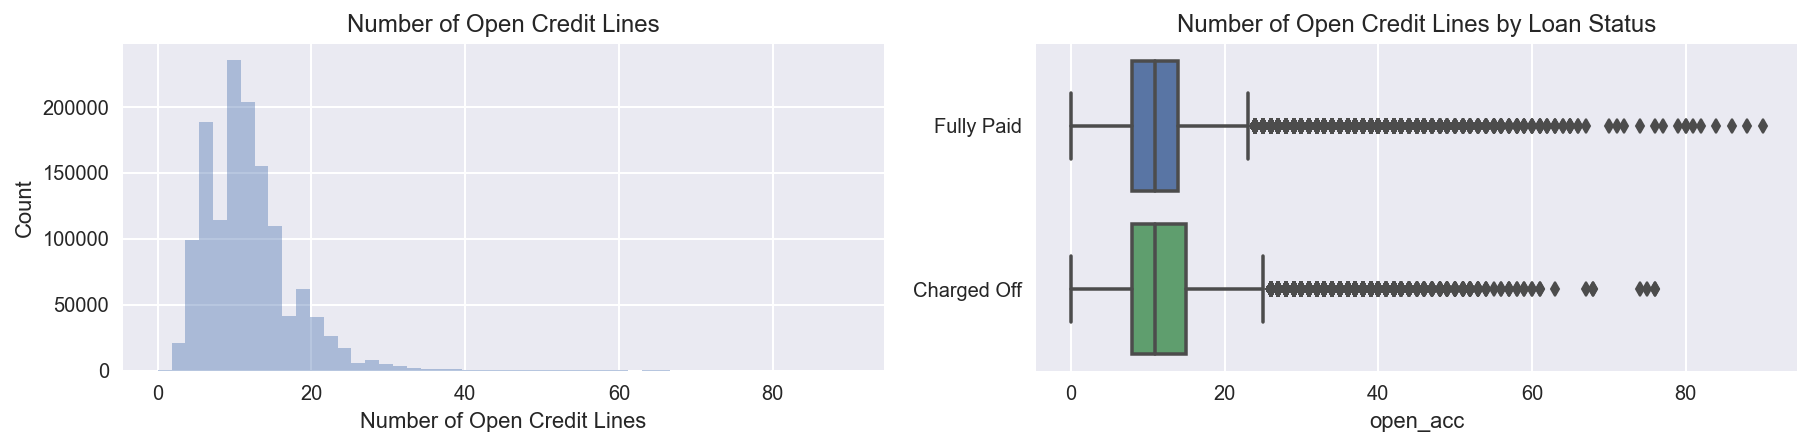

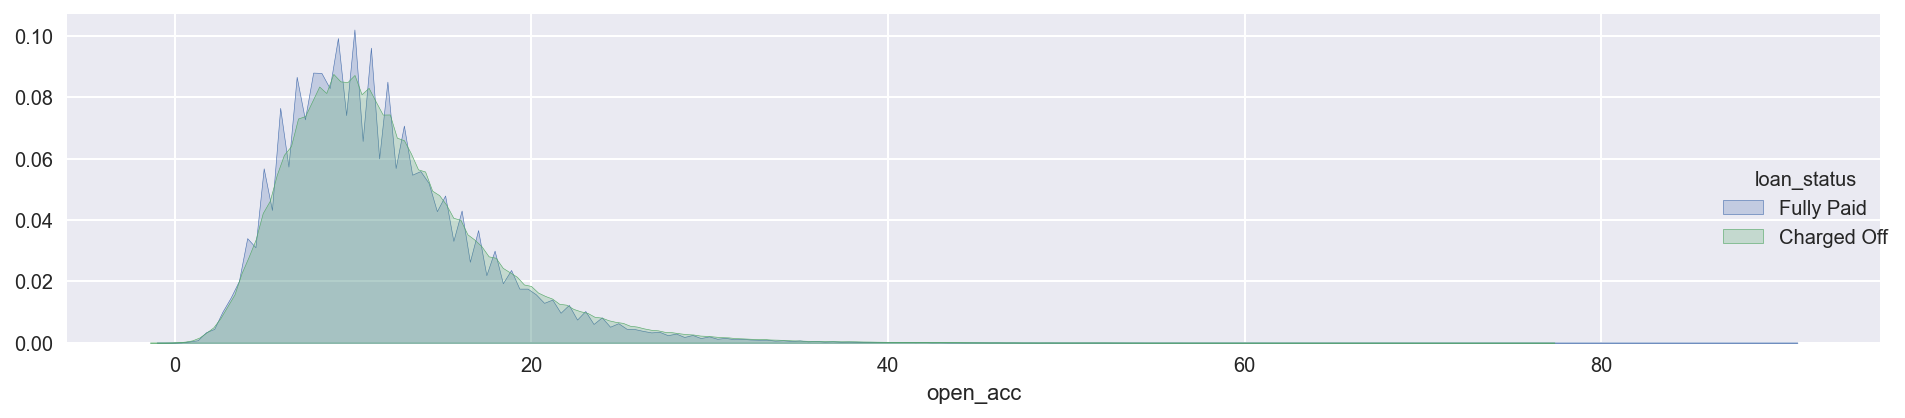

In [52]:
plot_var('open_acc', 'Number of Open Credit Lines', continuous=True)

There seems no significant difference in number of credit lines between fully paid loans and charged-off loans.

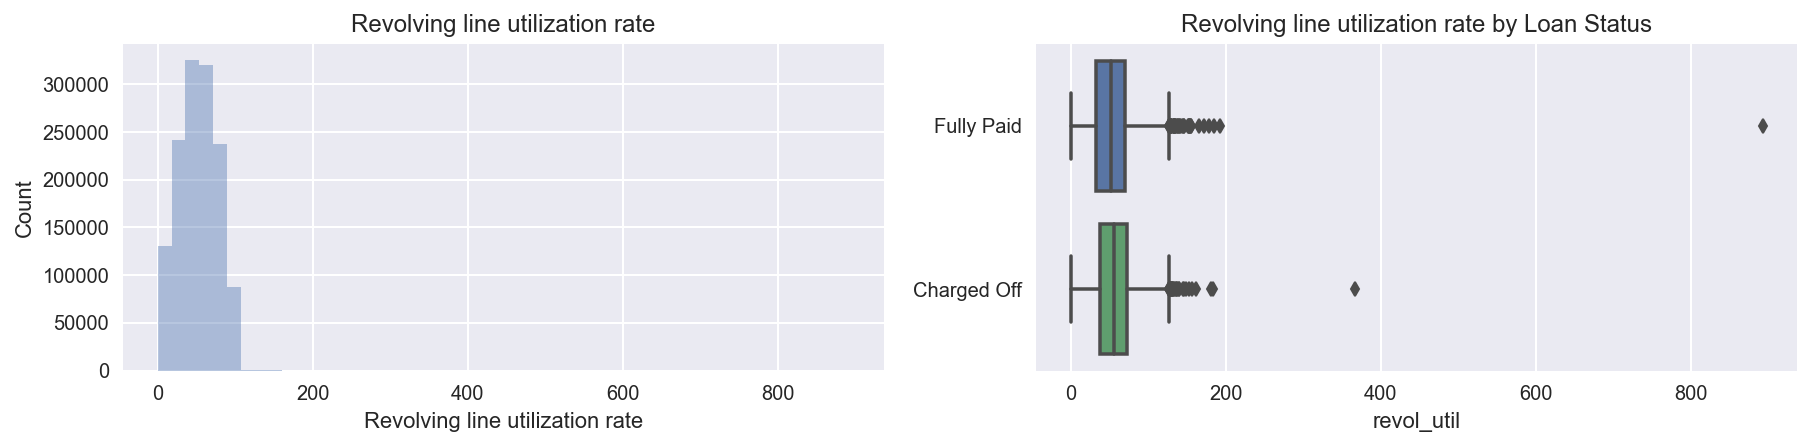

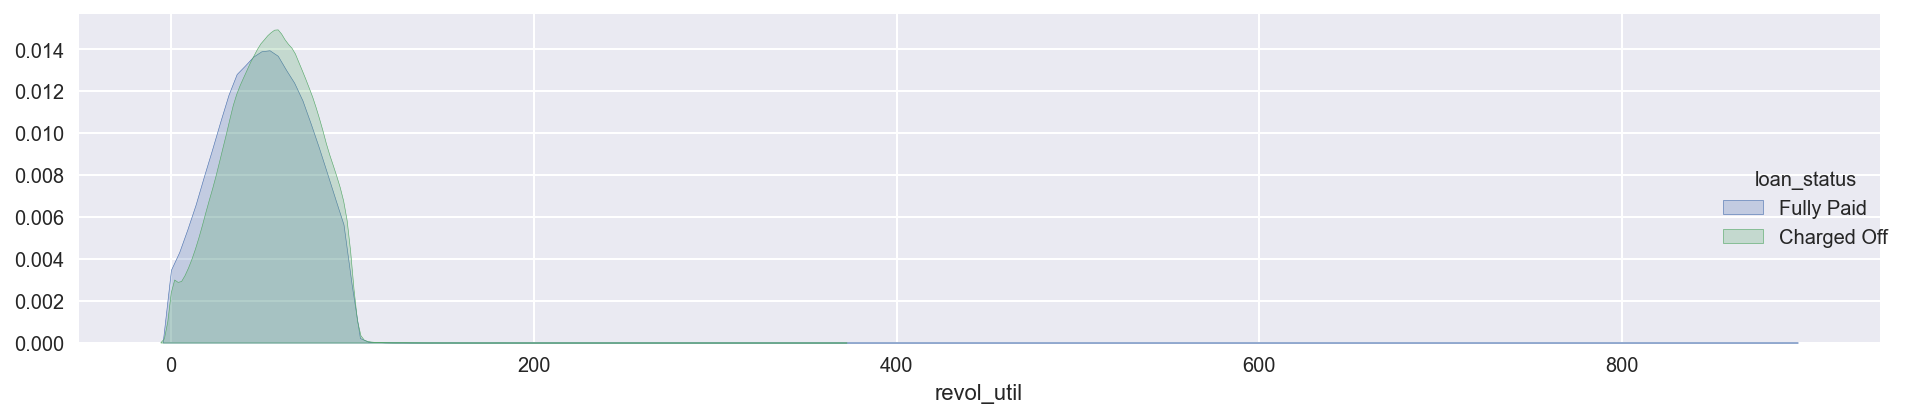

In [53]:
plot_var('revol_util', 'Revolving line utilization rate', continuous=True)

In [54]:
df.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268379.000,54.758,23.866,0.000,37.400,55.500,73.100,366.600
Fully Paid,1076074.000,51.075,24.627,0.000,32.500,51.300,70.100,892.300


Charged Off loans tend to have higher revol_util.

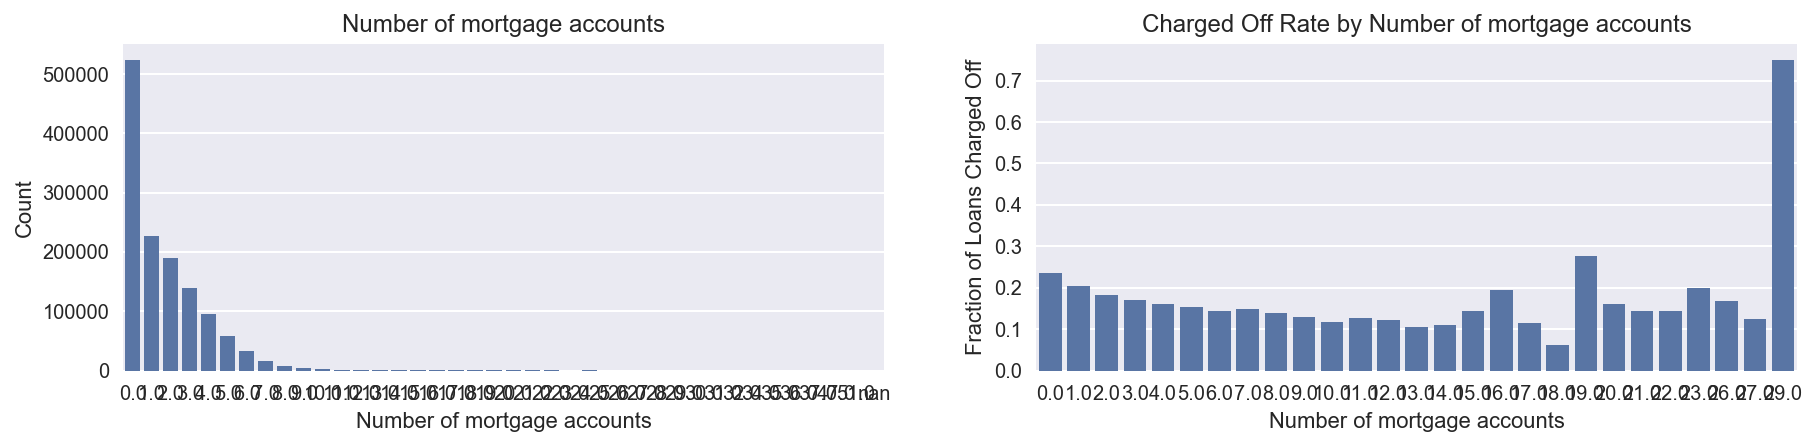

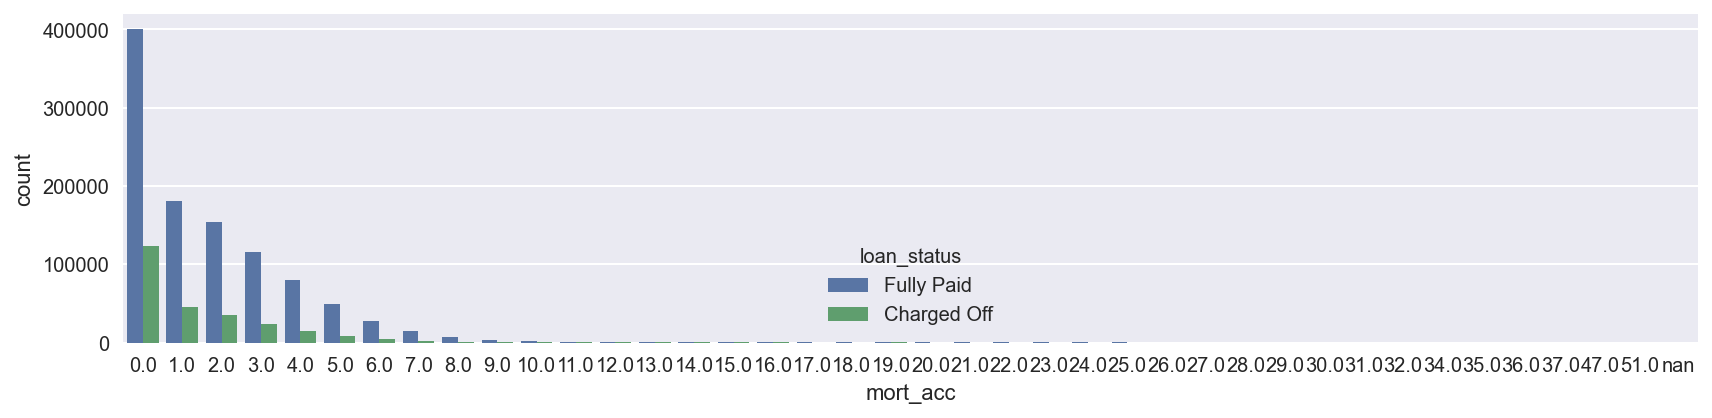

In [55]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=False)

In [56]:
df.mort_acc = df.mort_acc.map(lambda x: 6.0 if x > 6.0 else x)

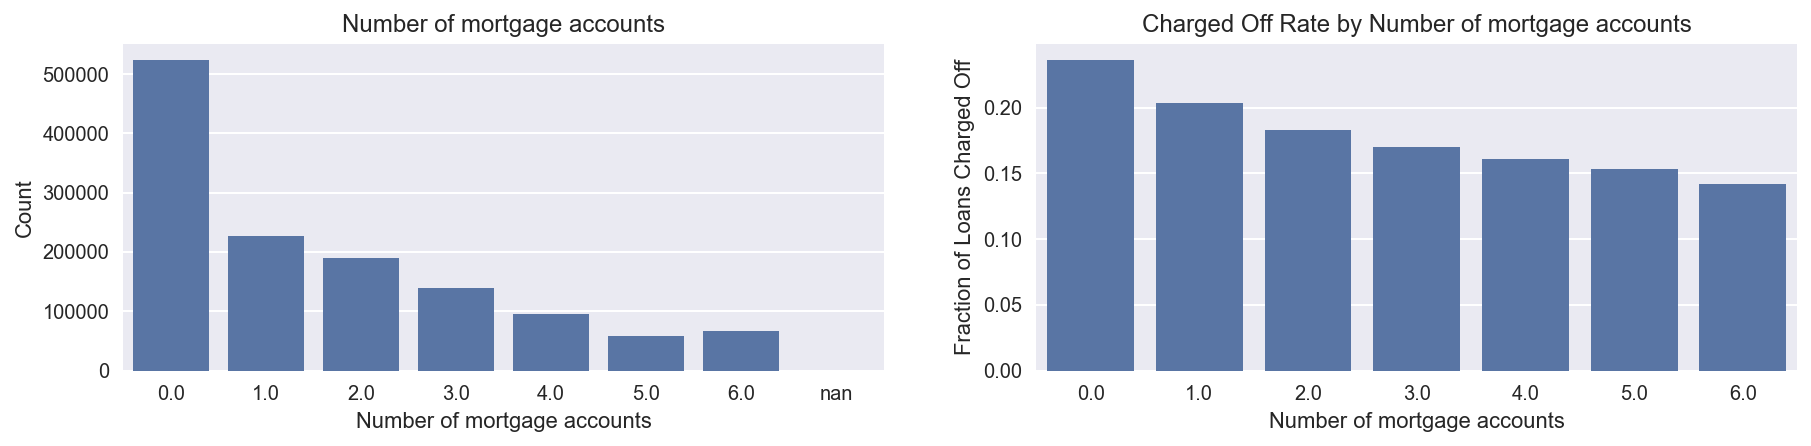

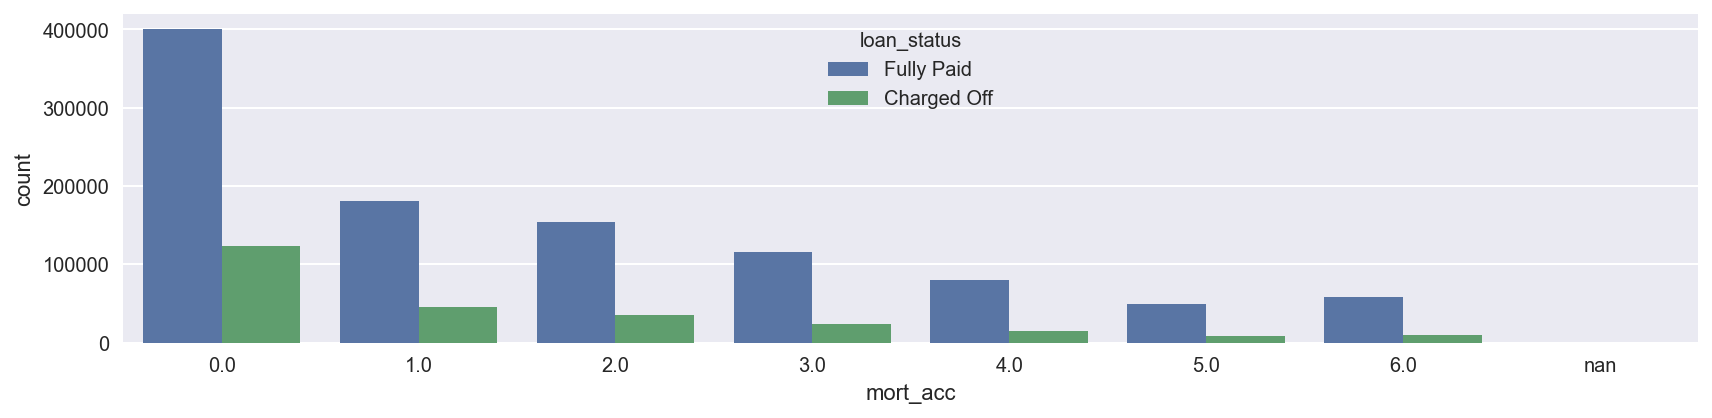

In [57]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=False)

In [58]:
df.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261673.000,1.333,1.683,0.000,0.000,1.000,2.000,6.000
Fully Paid,1036356.000,1.683,1.830,0.000,0.000,1.000,3.000,6.000


The more the number of mortgage accounts, the lower fraction of loans charged off.

In [59]:
df.head()

,loan_amnt,term,int_rate,installment,grade,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,log_income
0,3600.000,36 months,13.990,123.030,C,Fully Paid,debt_consolidation,5.910,7.000,0.000,2765.000,29.700,1.000,0.000,10.915
1,24700.000,36 months,11.990,820.280,C,Fully Paid,small_business,16.060,22.000,0.000,21470.000,19.200,4.000,0.000,11.082
2,20000.000,60 months,10.780,432.660,B,Fully Paid,home_improvement,10.780,6.000,0.000,7869.000,56.200,5.000,0.000,11.051
4,10400.000,60 months,22.450,289.910,F,Fully Paid,major_purchase,25.370,12.000,0.000,21929.000,64.500,6.000,0.000,11.556
5,11950.000,36 months,13.440,405.180,C,Fully Paid,debt_consolidation,10.200,5.000,0.000,8822.000,68.400,0.000,0.000,10.434


In [60]:
df.info()
# Turn the interest rate into a numerical feature
# df['int_rate'] = df['int_rate'].apply(lambda x: float(x[:-1])/100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1345310 non-null  float64
 1   term                  1345310 non-null  object 
 2   int_rate              1345310 non-null  float64
 3   installment           1345310 non-null  float64
 4   grade                 1345310 non-null  object 
 5   loan_status           1345310 non-null  object 
 6   purpose               1345310 non-null  object 
 7   dti                   1344936 non-null  float64
 8   open_acc              1345310 non-null  float64
 9   pub_rec               1345310 non-null  float64
 10  revol_bal             1345310 non-null  float64
 11  revol_util            1344453 non-null  float64
 12  mort_acc              1298029 non-null  float64
 13  pub_rec_bankruptcies  1344613 non-null  float64
 14  log_income            1345310 non-

In [61]:
def check_missing_value(df):
    '''Check for missing values in df 
        Print the column names and 
        the number of missing values in each column
    '''
    missing_value_column_name = []
    for i, j in zip(df.columns, df.isnull().sum(axis=0)):
        if j > 0:
            print(i, j, df[i].dtype)
            missing_value_column_name.append(i)
    print("The number of columns with missing values:",
          len(missing_value_column_name))

In [62]:
check_missing_value(df)

dti 374 float64
revol_util 857 float64
mort_acc 47281 float64
pub_rec_bankruptcies 697 float64
The number of columns with missing values: 4


In [63]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe

    OUTPUT
    df - a cleaned version of the original dataframe

    This function cleans df using the following steps :
    1. For each numerical variable, fill with the medium value of the column.
    2. For each categorical variable, fill with the mode value of the column.
    3. Convert 'emp_length', 'earliest_cr_line' and 'revol_util' to numerical
    variables.
    4. Oridinal encoding categorical variables.
    '''

    # Fill numerical columns with the medium
    # Models won't work with NA's
    # Lots of information will lose if simply dropping NA's
    # Distributions of numerical variables aren't normal（right-skewed）
    # So median would be a good representative 
    num_vars = df.select_dtypes(include=['number']).columns
    for col in num_vars:
        df[col].fillna((df[col].median()), inplace=True)

    # Fill categorical columns with the mode
    cat_vars = df.select_dtypes(include=['object']).columns
    for col in cat_vars:
        df[col].fillna((df[col].mode()[0]), inplace=True)

    # Convert to numerical variables.
    import re
    df['revol_util'] = df['revol_util'].astype('float') / 100.0

    # Ordinal encoding
    cat_vars = list(df.select_dtypes(include=['object']).columns)
    cat_vars.remove('loan_status')
    for var in cat_vars:
        class_mapping = {label:idx for idx, label in enumerate(np.unique(df[var]))}
        print(class_mapping)
        df[var]=df[var].map(class_mapping)
    return df

In [64]:
cleaned_df = clean_data(df)

{' 36 months': 0, ' 60 months': 1}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
{'car': 0, 'credit_card': 1, 'debt_consolidation': 2, 'educational': 3, 'home_improvement': 4, 'house': 5, 'major_purchase': 6, 'medical': 7, 'moving': 8, 'other': 9, 'renewable_energy': 10, 'small_business': 11, 'vacation': 12, 'wedding': 13}


In [65]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1345310 non-null  float64
 1   term                  1345310 non-null  int64  
 2   int_rate              1345310 non-null  float64
 3   installment           1345310 non-null  float64
 4   grade                 1345310 non-null  int64  
 5   loan_status           1345310 non-null  object 
 6   purpose               1345310 non-null  int64  
 7   dti                   1345310 non-null  float64
 8   open_acc              1345310 non-null  float64
 9   pub_rec               1345310 non-null  float64
 10  revol_bal             1345310 non-null  float64
 11  revol_util            1345310 non-null  float64
 12  mort_acc              1345310 non-null  float64
 13  pub_rec_bankruptcies  1345310 non-null  float64
 14  log_income            1345310 non-

In [66]:
cleaned_df.head()

,loan_amnt,term,int_rate,installment,grade,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,log_income
0,3600.000,0,13.990,123.030,2,Fully Paid,2,5.910,7.000,0.000,2765.000,0.297,1.000,0.000,10.915
1,24700.000,0,11.990,820.280,2,Fully Paid,11,16.060,22.000,0.000,21470.000,0.192,4.000,0.000,11.082
2,20000.000,1,10.780,432.660,1,Fully Paid,4,10.780,6.000,0.000,7869.000,0.562,5.000,0.000,11.051
4,10400.000,1,22.450,289.910,5,Fully Paid,6,25.370,12.000,0.000,21929.000,0.645,6.000,0.000,11.556
5,11950.000,0,13.440,405.180,2,Fully Paid,2,10.200,5.000,0.000,8822.000,0.684,0.000,0.000,10.434


Now let's examine whether any feature is heavily correlated with target variable in order to find features that contain information emerged after the issue of loan and thus unfit for prediction.

In [67]:
cleaned_df.to_csv('cleaned_df.csv', index=False)